In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

from numpy import mean
from numpy import std
from sklearn.datasets import make_regression
from sklearn.model_selection import RepeatedKFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,BatchNormalization,Flatten,Conv1D,MaxPooling1D,Dropout
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import zipfile
from numpy import array
from numpy import hstack

In [2]:
blocks = [1030, 2030, 3030]
#blocks = [1030, 2030, 3030, 4030, 5030, 6030, 7030]

dfss = []
for block in blocks:
    print(block)
    dfss.append(pd.read_csv('combined_df_'+str(block)+'.csv'))

1030
2030
3030


In [3]:
df = pd.concat(dfss)
df = pd.read_csv('combined_df_'+str(1030)+'.csv')

In [4]:
df.shape

(633401, 70)

In [5]:
def get_dataset():
    X = df[['Leading angle','Side tilt angle','Tool Tip Point X',
           'Tool Tip Point Y', 'Tool Tip Point Z', 'Tool Orientation X',
           'Tool Orientation Y', 'Tool Orientation Z',]].copy(deep=True).to_numpy()
    y = df[['MachineX', 'MachineY', 'MachineZ', 'MachineA', 'MachineC']].copy(deep=True).to_numpy()
    
    return X,y

(633401, 8) (633401, 5)
(601, 400, 8) (601, 5)
(601, 400, 8) (601, 5)
(480, 50, 8) (480, 5)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 46, 600)           24600     
_________________________________________________________________
batch_normalization_1 (Batch (None, 46, 600)           2400      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 23, 600)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 14, 600)           3600600   
_________________________________________________________________
flatten_1 (Flatten)          (None, 8400)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 150)               1260150   
____________________________

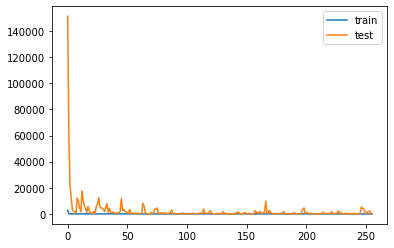

In [7]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in):
    X, y = list(), list()
   
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        
        # check if we are beyond the dataset
        if end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, 0:8], sequences[end_ix-1, 8:14]  # columns to see which are I/P and O/P features
        
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

# define input sequence
X,y = get_dataset()
print(X.shape,y.shape)
dataset = np.concatenate((X[0:1000,:],y[0:1000,:]),axis=1)  
#dataset = np.concatenate((X,y),axis=1)  

# choose a number of time steps
n_steps_in = 400
# convert into input/output
X, y = split_sequences(dataset, n_steps_in)
print(X.shape,y.shape)

num = 50
size = np.floor(n_steps_in/num)

sub_sampled = np.arange(0,n_steps_in,size, dtype=int)

X_sampled = np.empty((X.shape[0],sub_sampled.shape[0],X.shape[2]))
for i in np.arange(X.shape[0]):
    X_sampled[i] = X[i][sub_sampled][:]

print(X.shape,y.shape)

X_train, X_test, y_train, y_test = train_test_split(X_sampled, y, test_size=0.2, random_state=42)
print(X_train.shape,y_train.shape)

n_ip_features = X_train.shape[2]              
n_op_features = y_train.shape[1]
#print(n_op_features)
# define model
model = Sequential()
model.add(Conv1D(filters=600, kernel_size=5, activation='relu', input_shape=(num, n_ip_features)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=600, kernel_size=10, activation='relu'))
#model.add(Dropout(0.35))
model.add(Flatten())
model.add(Dense(150, activation='relu'))
model.add(Dense(n_op_features))

model.summary()
model.compile(optimizer='adam', loss='mse')   

early_stopping = EarlyStopping(monitor='val_loss', patience=100, mode='min')
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True, verbose=1)
# fit model
history = model.fit(X_train, y_train, epochs=2000,validation_data=(X_test,y_test), verbose=0,callbacks=[early_stopping,model_checkpoint], batch_size = 10)
          
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')

plt.legend()
plt.show()
# demonstrate prediction
#x_input = array([[70, 75], [80, 85], [90, 95]])
#x_input = x_input.reshape((1, n_steps_in, n_features))
#yhat = model.predict(x_input, verbose=0)
#print(yhat)